## Домашнее задание 5. Дизайн антитела, гуманизация

Из [PDB](https://www.rcsb.org) скачиваем белковые последовательности лёгкой и тяжёлой цепей мышиного антитела с PDB ID 3MBX.

In [ ]:
from Bio import SeqIO

records = list(SeqIO.parse("mouse_ab.fasta", "fasta"))
print('Тяжёлая цепь:', records[0].seq, 'Лёгкая цепь:', records[1].seq, sep='\n')

Тяжёлая цепь:
QVTLKESGPGILQPSQTLSLTCSFSGFSLSTYGMGVGWIRQPSGKGLEWLAHIWWDDVKRYNPALKSRLTISKDTSGSQVFLKIASVDTSDTATYYCARMGSDYDVWFDYWGQGTLVTVSAASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKKVEPKSCHHHHHH
Лёгкая цепь:
DIVMSQSPSSLAVSVGEKVTMSCKSSQSLLYNNNQKNYLAWYQQKPGQSPKLLIYWASTRESGVPDRFTGSGSGTDFTLTISSVKAEDLAVYYCQQYYSYPFTFGSGTKLEIKRADAAPTVSIFPPSSEQLTSGGASVVCFLNNFYPRDINVKWKIDGSERQNGVLNSWTDQDSKDSTYSMSSTLTLTKDEYERHNSYTCEATHKTSTSPIVKSFNRNEC


Для выделения вариабельных доменов используем [SAbDab](https://opig.stats.ox.ac.uk/webapps/sabdab-sabpred/sabdab/structureviewer/?pdb=3mbx#chains).

In [9]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

sequences = [SeqRecord(
    Seq("EVTLKESGPGILQPSQTLSLTCSFSGFSLSTYGMGVGWIRQPSGKGLEWLAHIWWDDVKRYNPALKSRLTISKDTSGSQVFLKIASVDTSDTATYYCARMGSDYDVWFDYWGQGTLVTVS"), 
    id="VH_mouse"),
    SeqRecord(
    Seq("DIVMSQSPSSLAVSVGEKVTMSCKSSQSLLYNNNQKNYLAWYQQKPGQSPKLLIYWASTRESGVPDRFTGSGSGTDFTLTISSVKAEDLAVYYCQQYYSYPFTFGSGTKLEIK"), 
    id="VL_mouse")]
with open("mouse_Fv.fasta", "w") as output_handle:
    SeqIO.write(sequences, output_handle, "fasta")
output_handle.close()

Для моделирования Fv-участка антитела используем сервис SAbPred [ABodyBuilder2](https://opig.stats.ox.ac.uk/webapps/sabdab-sabpred/sabpred/abodybuilder/).

![alt text](image.png)
Результаты: https://opig.stats.ox.ac.uk/webapps/sabdab-sabpred/sabpred/abodybuilder2_results/viewer/20251208_0643797/.

In [7]:
import py3Dmol as p3d

view = p3d.view()
view.addModel(open('mouse_fv_model.pdb', 'r').read(),'pdb')
view.setBackgroundColor('white')
view.setStyle({'chain':'H'}, {'cartoon': {'color':'purple'}})
view.setStyle({'chain':'L'}, {'cartoon': {'color':'green'}})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Ищем отличающиеся остатки мышиного антитела (only framework) при выравнивании с человеческом антителом с помощью <b>[DomainGapAlign](https://www.imgt.org/3Dstructure-DB/cgi/DomainGapAlign.cgi)</b>:

VH (отличия в 24 аминокислоты, первая находка: IGHV2-5*09 (71.4% идентичности)): 
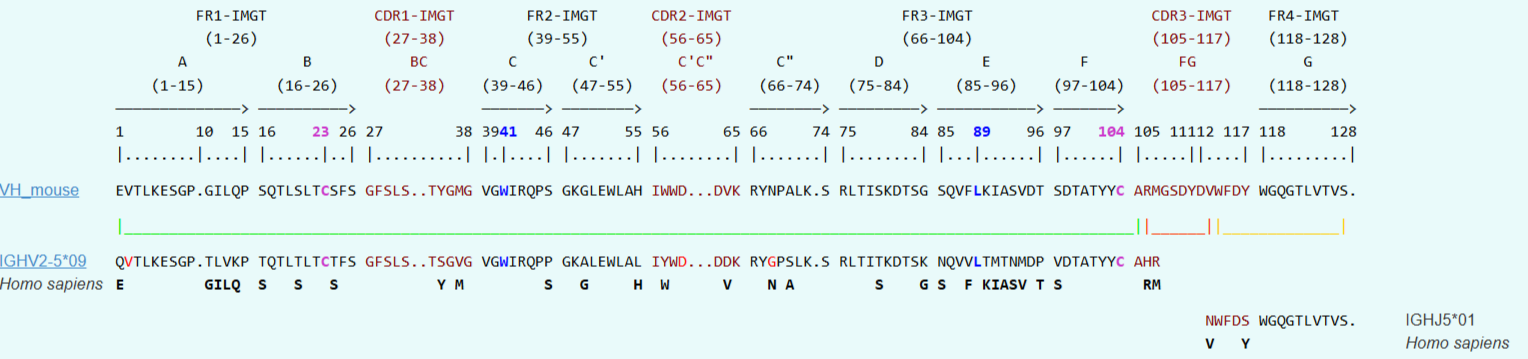

VL (отличия в 12 аминокислот, первая находка: IGKV4-1*01 (83.2% идентичности)):
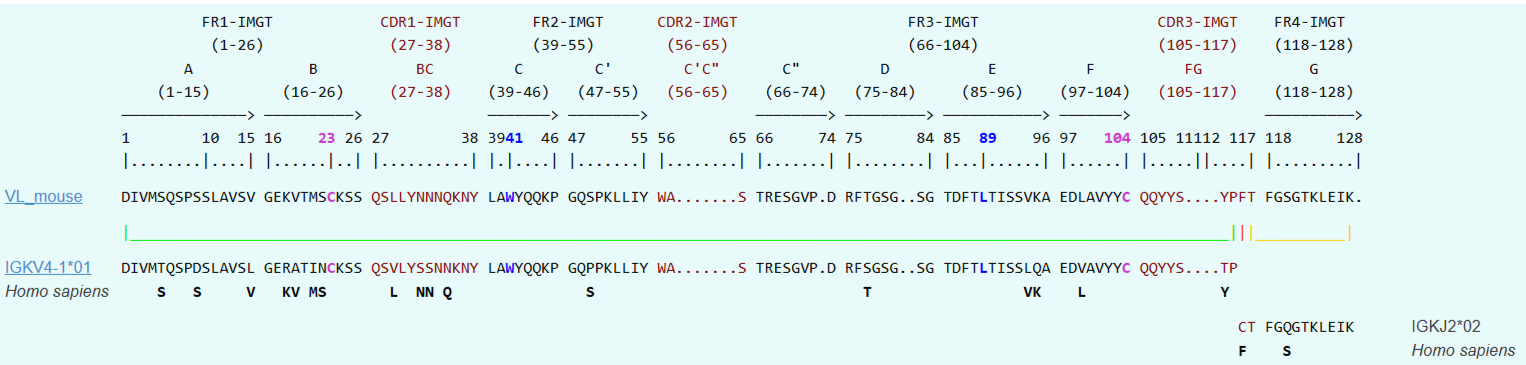

Заменяем в pymol отличающиеся остатки в FR-участках на человеческие (mutagenesis -> save as pdb <i>(без сортировки по номерам атомов, иначе spdbv не видит толком атомы, выдаёт ошибку "Missing atoms" и при расчёте энергии выдаёт ошибку (не может загрузить топологию аминокислот), но расчитывает её, вставляя OXT и HTT вместо мутированных остатков, причём такая проблема только у тяжёлой цепи)</i>):

1) В первый раз заменяла все аминокислоты на те, которые есть у человека и были выданы в результате выравнивания, но у Asp95 и Pro96 случился "clash", поэтому пролин был заменён на серин (по свойствам похож на треонин).
2) В качестве второго варианта заменяла остатки тяжёлой цепи таким образом, чтобы показатель "strain" при мутагенезе в pymol был минимальным, на лёгкой цепи - согласно выдаче DomainGapAlign.

Получали отчёт о расчёте энергии молекулы после мутагенеза с помощью [Swiss-PDBViewer](https://spdbv.unil.ch/content.html) в виде E#-файлов: Open PDB -> Select -> All -> Tools -> Compute Energy (Force Field).

In [ ]:
# цепи (тяжелая и лёгкая) для обоих вариантов

from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.Polypeptide import PPBuilder
from Bio.PDB.Chain import Chain

structure1 = PDBParser(QUIET=True).get_structure(id='mouse_mutV1', file='mouse_fv_model_mutV1.pdb')
structure2 = PDBParser(QUIET=True).get_structure(id='mouse_mutV2', file='mouse_fv_model_mutV2.pdb')
ppb=PPBuilder()
for pp in ppb.build_peptides(structure1):
    print('Версия 1:', pp.get_sequence())

for pp in ppb.build_peptides(structure2):
    print('Версия 2:', pp.get_sequence())

Версия 1: QVTLKESGPTLVKPTQTLTLTCTFSGFSLSTYGMGVGWIRQPPGKALEWLALIWWDDVKRYGPSLKSRLTITKDTSKNQVVLTMTNMDSVDTATYYCARMGSDYDVWFDYWGQGTLVTVS
Версия 1: DIVMTQSPDSLAVSLGERATINCKSSQSLLYNNNQKNYLAWYQQKPGQPPKLLIYWASTRESGVPDRFSGSGSGTDFTLTISSLQAEDVAVYYCQQYYSYPFTFGSGTKLEIK
Версия 2: QVTLKESGPYKCKPTQTLTLTCTFSGFSLSTYGMGVGWIRQPPGKALEWLALIWWDDVKRYQPSLKSRLTITKDTSKNQVVLIMKGNDWVDTATYYCARMGSDYDVWFDYWGQGTLVTVS
Версия 2: DIVMTQSPDSLAVSLGERATINCKSSQSLLYNNNQKNYLAWYQQKPGQPPKLLIYWASTRESGVPDRFSGSGSGTDFTLTISSLQAEDVAVYYCQQYYSYPFTFGSGTKLEIK


In [47]:
import pandas as pd

energy_1 = pd.read_table('energy_mouse_mutV1.E3', delim_whitespace=True, skiprows = 8, names=['residue', 'atom', 'resi', 'bonds', 'angles', 'torsion', 'improper', 
                                                                                 'nonBonded', 'electrostatic', 'constraint', '//', 'E=', 'TOTAL'],
                                                                                 keep_default_na=False)
energy_1

C:\Users\Я\AppData\Local\Temp\ipykernel_21348\686142985.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  energy_1 = pd.read_table('energy_mouse_mutV1.E3', delim_whitespace=True, skiprows = 8, names=['residue', 'atom', 'resi', 'bonds', 'angles', 'torsion', 'improper',


,residue,atom,resi,bonds,angles,torsion,improper,nonBonded,electrostatic,constraint,//,E=,TOTAL
0,HHT,H,1,0.000,6.183,7.540,0.000,0.00,0.25,0.0000,//,E=,13.977
1,GLN,H,1,4.249,12.641,2.599,0.027,-10.70,-30.16,0.0000,//,E=,-21.345
2,VAL,H,2,0.676,6.010,5.256,0.694,-19.79,9.54,0.0000,//,E=,2.381
3,THR,H,3,0.860,4.345,2.116,0.621,-18.55,-17.86,0.0000,//,E=,-28.468
4,LEU,H,4,1.206,7.291,9.869,0.400,-51.60,-1.34,0.0000,//,E=,-34.179
...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,ILE,L,126,1.258,4.772,2.176,1.226,-25.51,3.89,0.0000,//,E=,-12.188
235,LYSH,L,127,1.892,10.435,20.315,0.036,-28.54,75.33,0.0000,//,E=,79.462
236,OXT,L,127,0.000,0.000,0.000,0.000,-2.54,-2.24,0.0000,//,E=,-4.788
237,//--------------------------------------------...,,,,,,,,,,,,


In [48]:
import pandas as pd

energy_2 = pd.read_table('energy_mouse_mutV2.E2', delim_whitespace=True, skiprows = 8, names=['residue', 'atom', 'resi', 'bonds', 'angles', 'torsion', 'improper', 
                                                                                 'nonBonded', 'electrostatic', 'constraint', '//', 'E=', 'TOTAL'],
                                                                                 keep_default_na=False)
energy_2

C:\Users\Я\AppData\Local\Temp\ipykernel_21348\4105455932.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  energy_2 = pd.read_table('energy_mouse_mutV2.E2', delim_whitespace=True, skiprows = 8, names=['residue', 'atom', 'resi', 'bonds', 'angles', 'torsion', 'improper',


,residue,atom,resi,bonds,angles,torsion,improper,nonBonded,electrostatic,constraint,//,E=,TOTAL
0,HHT,H,1,0.000,6.183,7.540,0.000,0.00,0.44,0.0000,//,E=,14.165
1,GLN,H,1,4.249,12.641,2.599,0.027,-10.70,-30.33,0.0000,//,E=,-21.512
2,VAL,H,2,0.676,6.010,5.256,0.694,-19.80,9.53,0.0000,//,E=,2.370
3,THR,H,3,0.860,4.345,2.116,0.621,-18.55,-17.84,0.0000,//,E=,-28.446
4,LEU,H,4,1.206,7.291,9.869,0.400,-51.61,-1.36,0.0000,//,E=,-34.204
...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,ILE,L,126,1.258,4.772,2.176,1.226,-25.51,3.89,0.0000,//,E=,-12.191
235,LYSH,L,127,1.892,10.435,20.315,0.036,-28.54,75.58,0.0000,//,E=,79.712
236,OXT,L,127,0.000,0.000,0.000,0.000,-2.54,-2.50,0.0000,//,E=,-5.044
237,//--------------------------------------------...,,,,,,,,,,,,


Мы получили гуманизированное антитело!